Load the image

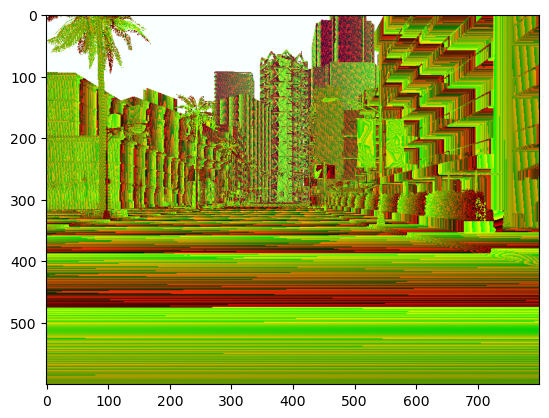

In [244]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

 
# Read Images
img = mpimg.imread('Rubens test files/Pictures/depth_camera_Sun_Apr_14_20_33_08_2024.png') #to check the picture
img2 = mpimg.imread('Rubens test files/Pictures/instance_camera_Sun_Apr_14_20_33_08_2024.png')
depth_data=plt.imread('Rubens test files/Pictures/depth_camera_Sun_Apr_14_20_33_08_2024.png') #to get the data as an array
segment_data=plt.imread('Rubens test files/Pictures/instance_camera_Sun_Apr_14_20_33_08_2024.png') #to get the data as an array
# Output Images
plt.imshow(img)
#plt.imshow(img2)



Initiate variables

In [245]:
depth_Width=depth_data[1,:,0].size
depth_Height=depth_data[:,1,0].size
print([depth_Height,depth_Width])

segment_Width=round(segment_data[1,:,0].size/3)
segment_Height=round(segment_data[:,1,0].size/3)


converted_depth_data=np.zeros([depth_Width,depth_Height])
segment_data=np.round(segment_data*255)


max_sensor_range= 0.4 #in kilometers
depth_data[0,0,0]

#w2c=camera.get_transform
depth_Height


[600, 800]


600

In [246]:
# def get_image_point(loc, K,w2c):
#         # Calculate 2D projection of 3D coordinate

#         # Format the input coordinate (loc is a carla.Position object)
#         point = np.array([loc.x, loc.y, loc.z, 1])
#         # transform to camera coordinates
#         point_camera = np.dot(w2c, point)

#         # New we must change from UE4's coordinate system to an "standard"
#         # (x, y ,z) -> (y, -z, x)
#         # and we remove the fourth componebonent also
#         point_camera = [point_camera[1], -point_camera[2], point_camera[0]]

#         # now project 3D->2D using the camera matrix
#         point_img = np.dot(K, point_camera)
#         # normalize
#         point_img[0] /= point_img[2]
#         point_img[1] /= point_img[2]

#         return point_img[0:2]

def get_point_image(point_img,K_inv,Width,Height):
        loc_mat=np.zeros([Height,Width,3])
        static_projection_matrix=np.zeros([Height,Width,3])
        for i in range(Height):
                for j in range(Width):
                        loc_mat[i,j] = [j-Width/2,i-Height/2,1]
                        static_projection_matrix[i,j]=np.dot(K_inv,loc_mat[i,j])
        return static_projection_matrix , loc_mat
        
        
def get_point_world_coordinates(point_img, K_inv, R, t, Height, Width):
    loc_mat = np.zeros([Height, Width, 3])  # Corrected dimensions
    camera_coordinates = np.zeros([Height, Width, 3])  # Corrected dimensions
    world_coordinates = np.zeros([Height, Width, 3])  # Corrected dimensions
    for i in range(Height):
        for j in range(Width):  # Corrected order of Height and Width
            loc_mat[i, j] = [j, i, 1]  # Corrected order of j and i
            camera_coordinates[i, j] = np.dot(K_inv, loc_mat[i, j]) * point_img[i, j]  
            world_coordinates[i, j] = np.dot(R, camera_coordinates[i, j]) + t
    return world_coordinates

Calculate costmap


In [247]:
#convert depth units
R=depth_data[:,:,0]
G=depth_data[:,:,1]
B=depth_data[:,:,2]

normalized = ((R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1))*1000*100

#calculate projection matrix
fov = 90
im_size_x = 800
im_size_y = 600

f  = im_size_x /(2.0 * math.tan(fov * math.pi / 360))
Cx = im_size_x / 2.0
Cy = im_size_y / 2.0

K = np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]], dtype=np.float64)
K_inv=np.linalg.inv(K)

#convert the image data to points

[rel_coords,camera_index_mat]=get_point_image(normalized,K_inv,depth_Width,depth_Height)
#camera_index_mat= get_point_world_coordinates(depth_data, K_inv, [[1,0,0],[0,1,0],[0,0,1]], [0,0,0], depth_Height, depth_Width)

print(normalized)

#np.save(r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\code', normalized)

[[392.15672305 392.15672305 392.15672305 ...   4.99465925   4.98255133
    4.97462745]
 [392.15672305 392.15672305 392.15672305 ...   4.99465925   4.98255133
    4.97460417]
 [392.15672305 392.15672305 392.15672305 ...   4.99465925   4.98255133
    4.97455724]
 ...
 [  0.90147947   0.90147947   0.90147947 ...   0.90080162   0.90080162
    0.90080162]
 [  0.89844076   0.89844076   0.89844076 ...   0.89776291   0.89776291
    0.89776291]
 [  0.89542551   0.89542551   0.89542551 ...   0.89474766   0.89474766
    0.89474766]]


In [248]:
print(camera_index_mat)
#np.save(r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\code', camera_index_mat)
f

[[[-400. -300.    1.]
  [-399. -300.    1.]
  [-398. -300.    1.]
  ...
  [ 397. -300.    1.]
  [ 398. -300.    1.]
  [ 399. -300.    1.]]

 [[-400. -299.    1.]
  [-399. -299.    1.]
  [-398. -299.    1.]
  ...
  [ 397. -299.    1.]
  [ 398. -299.    1.]
  [ 399. -299.    1.]]

 [[-400. -298.    1.]
  [-399. -298.    1.]
  [-398. -298.    1.]
  ...
  [ 397. -298.    1.]
  [ 398. -298.    1.]
  [ 399. -298.    1.]]

 ...

 [[-400.  297.    1.]
  [-399.  297.    1.]
  [-398.  297.    1.]
  ...
  [ 397.  297.    1.]
  [ 398.  297.    1.]
  [ 399.  297.    1.]]

 [[-400.  298.    1.]
  [-399.  298.    1.]
  [-398.  298.    1.]
  ...
  [ 397.  298.    1.]
  [ 398.  298.    1.]
  [ 399.  298.    1.]]

 [[-400.  299.    1.]
  [-399.  299.    1.]
  [-398.  299.    1.]
  ...
  [ 397.  299.    1.]
  [ 398.  299.    1.]
  [ 399.  299.    1.]]]


400.00000000000006

c:\Users\20192709\AppData\Local\anaconda3\envs\Carla3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


(0.0, 100.0)

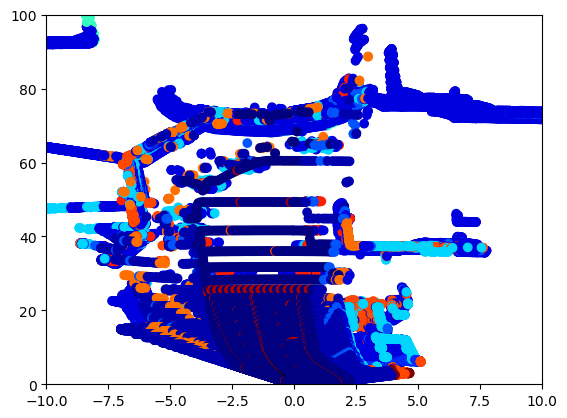

In [249]:
#we use np.division to quickly do elementwise matrix division where dividing by 0 equals 1


focal_mat=np.ones_like(rel_coords[:,:,0])
camera_index_mat=rel_coords

c_squared=np.square(focal_mat)+np.square(camera_index_mat[:,:,1])
d=np.power(np.square(camera_index_mat[:,:,0])+c_squared, 0.5*np.ones_like(camera_index_mat[:,:,0]))

#Create a condition to bypass the division incase of zeros
condition= (np.square(camera_index_mat[:,:,0]) + np.square(camera_index_mat[:,:,1]))!=0

#cant put a scalar in np.divide so we use ones
placeholder=np.ones_like(camera_index_mat[:,:,0])

a  = np.divide(placeholder, d, out=np.zeros_like(placeholder), where= condition)

x= a*normalized*(camera_index_mat[:,:,0]+1)
y= a*normalized*(camera_index_mat[:,:,1]+.75)
z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2)) #This loses some values but i cannot figure out why.


#z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2),where=(np.power(normalized,2)-np.power(x,2)-np.power(y,2))<0,out=np.zeros_like(normalized))

#z[z>1.1] =0
#camera_index_mat[z==0] =[0,0,0]
#np.save(r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\code', z)
plt.scatter(x,z,c=segment_data[:,:,0],cmap='jet')
plt.xlim(-10,10)
plt.ylim(0,100)

(0.0, 100.0)

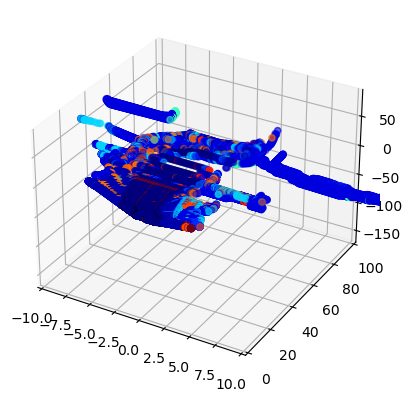

In [255]:
x[np.isnan(x)==True]=0
y[np.isnan(y)==True]=0
z[np.isnan(z)==True]=0

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(x,z,y,c=segment_data[:,:,0],cmap='jet')
plt.xlim(-10,10)
plt.ylim(0,100)



(0.0, 80.0)

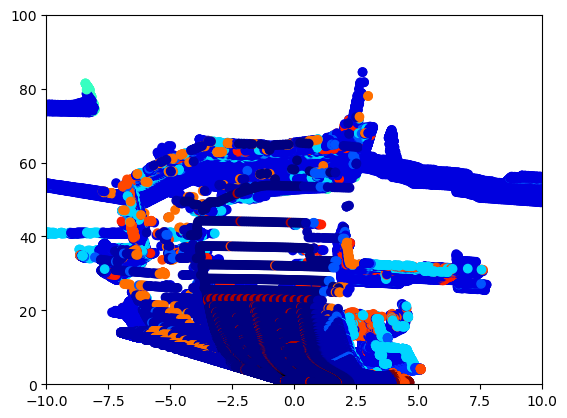

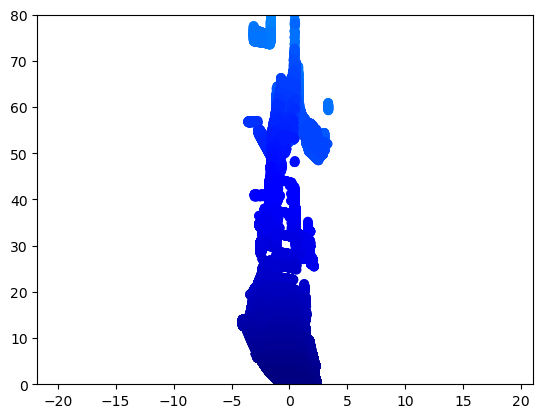

In [ ]:


plt.figure()
plt.scatter((camera_index_mat[:,:,0]+1)*np.sqrt(normalized),z,c=normalized,cmap='jet')
plt.ylim(0,80)

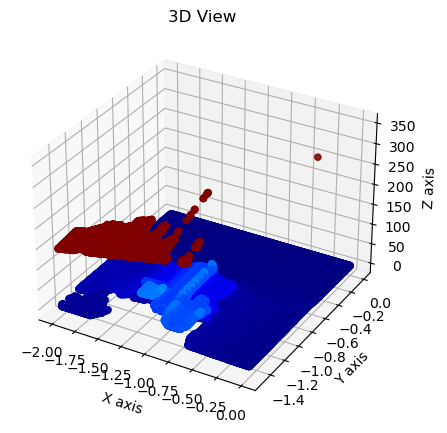

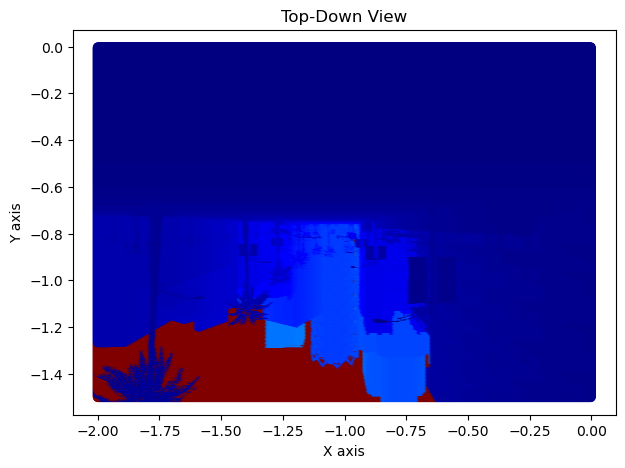

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# # Load the arrays from the files
# camera_index_mat = np.load('/mnt/data/camera_index_mat.npy')
# z = np.load('/mnt/data/z.npy')
# normalized = np.load('/mnt/data/normalized.npy')

# Reshape z for consistency
z = z.reshape(camera_index_mat.shape[:2])

# Prepare data for plotting
x_data = camera_index_mat[:, :, 0]
y_data = camera_index_mat[:, :, 1]
z_data = z
color_data = normalized

# Create 3D scatter plot
fig_3d = plt.figure(figsize=(7, 5))
ax_3d = fig_3d.add_subplot(111, projection='3d')
scatter3d = ax_3d.scatter(x_data, y_data, z_data, c=color_data, cmap='jet')
ax_3d.set_title('3D View')
ax_3d.set_xlabel('X axis')
ax_3d.set_ylabel('Y axis')
ax_3d.set_zlabel('Z axis')

plt.show()

# # Save 3D plot to a file
# scatter_3d_filename = r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\code/scatter_3d.png'
# plt.savefig(scatter_3d_filename)
# plt.close(fig_3d)

# Create top-down (XY) scatter plot
fig_xy = plt.figure(figsize=(7, 5))
ax_xy = fig_xy.add_subplot(111)
scatter_xy = ax_xy.scatter(x_data, y_data, c=color_data, cmap='jet')
ax_xy.set_title('Top-Down View')
ax_xy.set_xlabel('X axis')
ax_xy.set_ylabel('Y axis')

plt.show()

# # Save top-down plot to a file
# scatter_xz_filename = r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\codescatter_xz.png'
# plt.savefig(scatter_xz_filename)
# plt.close(fig_xz)




(-2.5, 2.5)

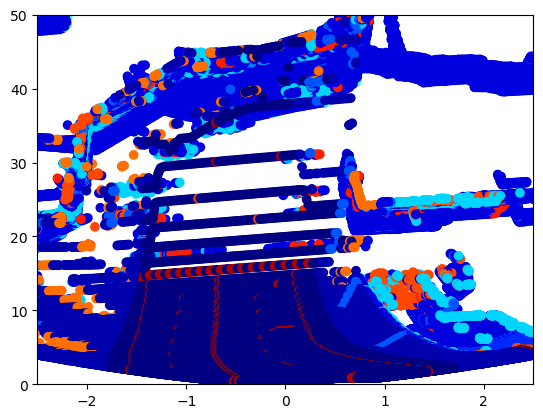

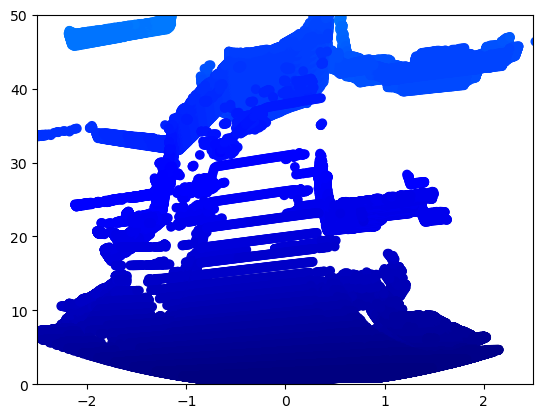

In [ ]:
plt.scatter((camera_index_mat[:,:,0]+1)*np.power(z,2/3),z,c=segment_data[:,:,0],cmap='jet')
plt.ylim(0,50)
plt.xlim(-2.5,2.5)
#plt.xlim(0,-0.005)
#plt.ylim(0,1)
plt.figure()
plt.scatter((camera_index_mat[:,:,0]+1)*np.power(z,1/2),z,c=normalized,cmap='jet')
plt.ylim(0,50)
plt.xlim(-2.5,2.5)

ValueError: x must have 2 or fewer dimensions

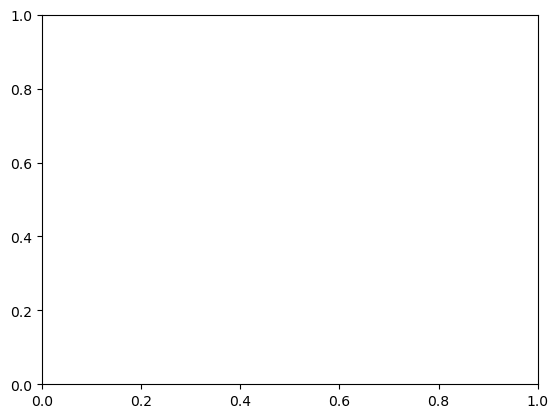

In [ ]:
plt.hist(camera_index_mat[:,:,])
plt.show